In [1]:
from spec_exam import Gen_spec
from spec_stats import Highest_density_region
from sim_engine import *
from spec_extract import Scale_model
from astropy.table import Table
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from glob import glob
from spec_tools import Source_present, Smooth, Median_w_Error_cont
from grizli import multifit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sea
import fsps
import os
import numpy as np
from scipy.interpolate import RegularGridInterpolator
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

import dynesty
from dynesty import plotting as dyplot
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [5]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau = 0.1,
                           dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.2539,
               g102_lims=[7900, 11500], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = True)  

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [17]:
lwvs = ilwagrid([0.83,0.26])[0]

interp1d(lwvs,age_range)(2.2)

array(2.82791655)

In [41]:
sp.params['logzsol'] = np.log10( 0.3 )
sp.params['tau'] = 0.51
sp.params['dust2'] = 0.2
# array([0.3       , 4.9       , 0.51      , 1.25377875, 0.2       ])

wave, flux = sp.get_spectrum(tage = 4.9, peraa = True)

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, 1.25377)

PC= Full_scale(Gs, Pmfl)

Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC*Bmfl)
Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC*Rmfl)

Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)
                  

In [43]:
print(Bchi, Rchi, Pchi)

98.5368139226924 69.31667435334444 18.834886233959722


([<matplotlib.axis.XTick at 0x1a847e1940>,
 <a list of 6 Text xticklabel objects>)

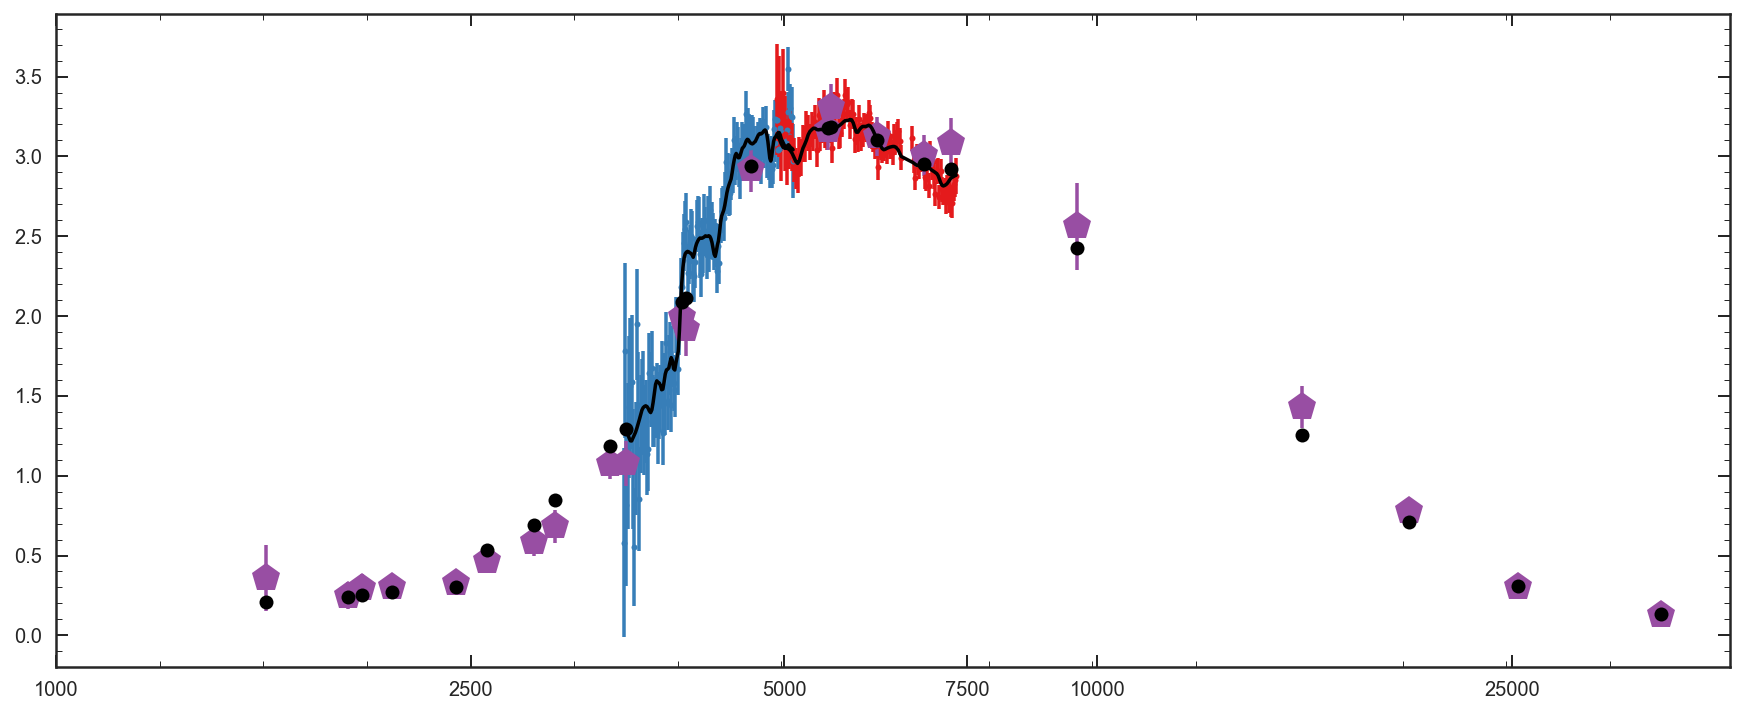

In [44]:
plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18/ Bscale,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18/ Rscale,Gs.Rer*1E18/ Rscale,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC * Bmfl*1E18, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC * Rmfl*1E18, 'k', zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC * Pmfl*1E18, 'ko', zorder=5)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

In [16]:
template_path = '../templates/'
    
tau_range = np.load(template_path + 'tau_range.npy')
metal_range = np.load(template_path + 'metal_range.npy')
age_range = np.load(template_path + 'age_range.npy')
lwagrid = np.load(template_path + 'lwa_grid.npy')

ilwagrid = RegularGridInterpolator([metal_range,tau_range],lwagrid)

In [22]:
specz = 1.2529
def rshift_prior_transform(u):
    m = np.array((0.03 * u[0]) / 0.019 * 10).astype(int) / 10 + 0.1
    a = np.array(5. * u[1] * 10 / 2).astype(int) / 10  * 2 + 0.1
    t = np.array(2 * u[2] * 10).astype(int) / 10 + 0.01
    z = specz + 0.02 * (2 * u[3] - 1)
    d = np.array(u[4] * 11 ).astype(int) / 10 
        
    return [m, a, t, z, d]

In [23]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)


def Full_forward_model(spec, wave, flux, specz):
    Bmfl = forward_model_all_beams(spec.Bbeam, spec.Btrans, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = forward_model_all_beams(spec.Rbeam, spec.Rtrans, spec.Rwv, wave * (1 + specz), flux)
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Pmfl):
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    return PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):

    Bscale = Scale_model(spec.Bfl, spec.Ber, Bmfl)
    Rscale = Scale_model(spec.Rfl, spec.Rer, Rmfl)

    Bchi = np.sum(((((spec.Bfl/ Bscale) - Bmfl) / (spec.Ber / Bscale))**2))
    Rchi = np.sum(((((spec.Rfl/ Rscale) - Rmfl) / (spec.Rer / Rscale))**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Bchi, Rchi, Pchi

def rshift_loglikelihood(X):
    m,a,t,z,d = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['tau'] = t
    sp.params['dust2'] = d
       
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
        
    Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
    
    PC= Full_scale(Gs, Pmfl)

    Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)
                  
    return -0.5 * (Bchi + Rchi + Pchi)


In [24]:
import ipyparallel as ipp

rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

dview = rc[:]
dview.use_dill();

class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

[0, 1, 2, 3, 4, 5]


In [25]:
%%px

# import environment
import fsps
from spec_exam import Gen_spec
from sim_engine import *
import dynesty
from scipy.interpolate import RegularGridInterpolator

specz = 1.2529

tau_range = np.load(template_path + 'tau_range.npy')
metal_range = np.load(template_path + 'metal_range.npy')
age_range = np.load(template_path + 'age_range.npy')
lwagrid = np.load(template_path + 'lwa_grid.npy')
ilwagrid = RegularGridInterpolator([metal_range,tau_range],lwagrid)

sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau = 0.1,
                           dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.2539,
               g102_lims=[7900, 11500], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = True)  

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)


def Full_forward_model(spec, wave, flux, specz):
    Bmfl = forward_model_all_beams(spec.Bbeam, spec.Btrans, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = forward_model_all_beams(spec.Rbeam, spec.Rtrans, spec.Rwv, wave * (1 + specz), flux)
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Pmfl):
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    return PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):

    Bscale = Scale_model(spec.Bfl, spec.Ber, Bmfl)
    Rscale = Scale_model(spec.Rfl, spec.Rer, Rmfl)

    Bchi = np.sum(((((spec.Bfl/ Bscale) - Bmfl) / (spec.Ber / Bscale))**2))
    Rchi = np.sum(((((spec.Rfl/ Rscale) - Rmfl) / (spec.Rer / Rscale))**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Bchi, Rchi, Pchi

# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:',os.getpid())

[stdout:0] 
cleaned
Random seed: 86960
[stdout:1] 
cleaned
Random seed: 86961
[stdout:2] 
cleaned
Random seed: 86962
[stdout:3] 
cleaned
Random seed: 86965
[stdout:4] 
cleaned
Random seed: 86966
[stdout:5] 
cleaned
Random seed: 86969


[stderr:0] 
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
[stderr:1] 
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**

In [28]:
dsampler = dynesty.DynamicNestedSampler(rshift_loglikelihood, rshift_prior_transform, ndim = 5,bound='single', sample = 'rwalk',
                                       pool=pool) 

In [29]:
dsampler.run_nested(maxiter = 7000, nlive_init=250, maxiter_batch=1000,wt_kwargs={'pfrac': 1.0}, dlogz_init=0.1, print_progress=True)

iter: 7277 | batch: 4 | bound: 440 | nc: 25 | ncall: 163493 | eff(%):  4.451 | loglstar: -97.965 < -93.394 < -97.566 | logz: -105.383 +/-  0.193 | stop:    nan            


In [30]:
dres = dsampler.results

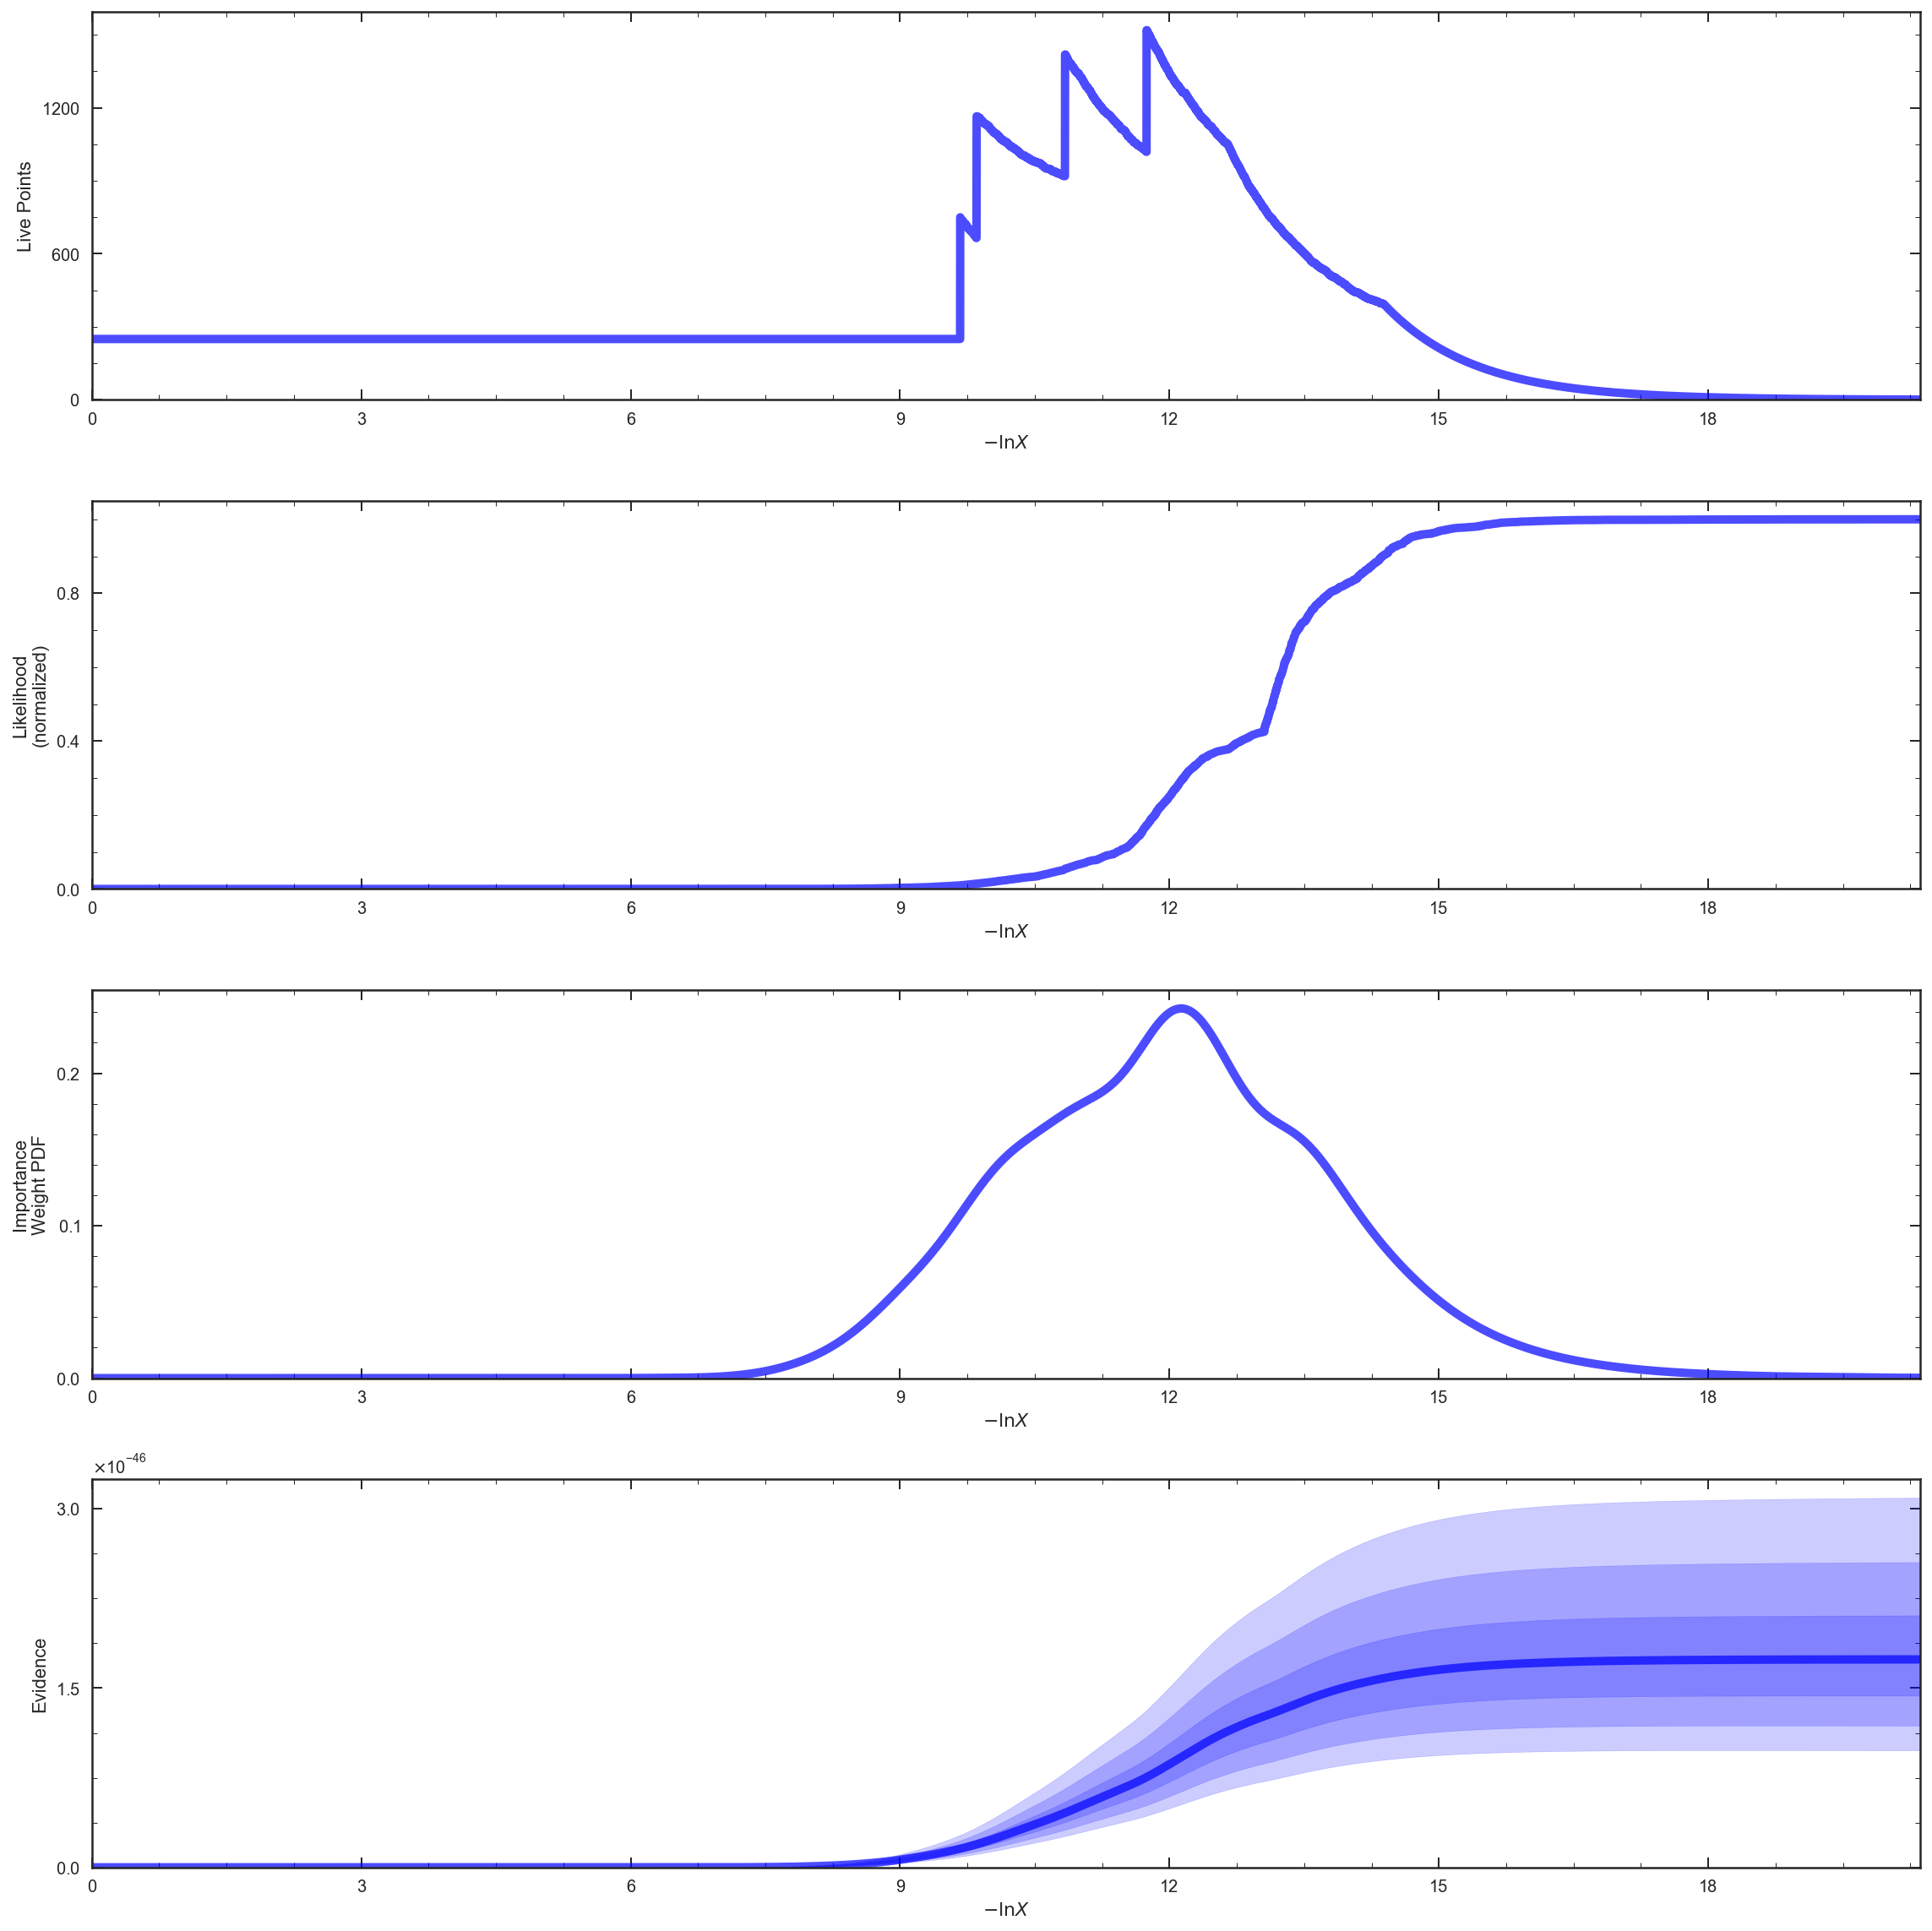

In [31]:
fig, axes = dyplot.runplot(dres)

fig.tight_layout()

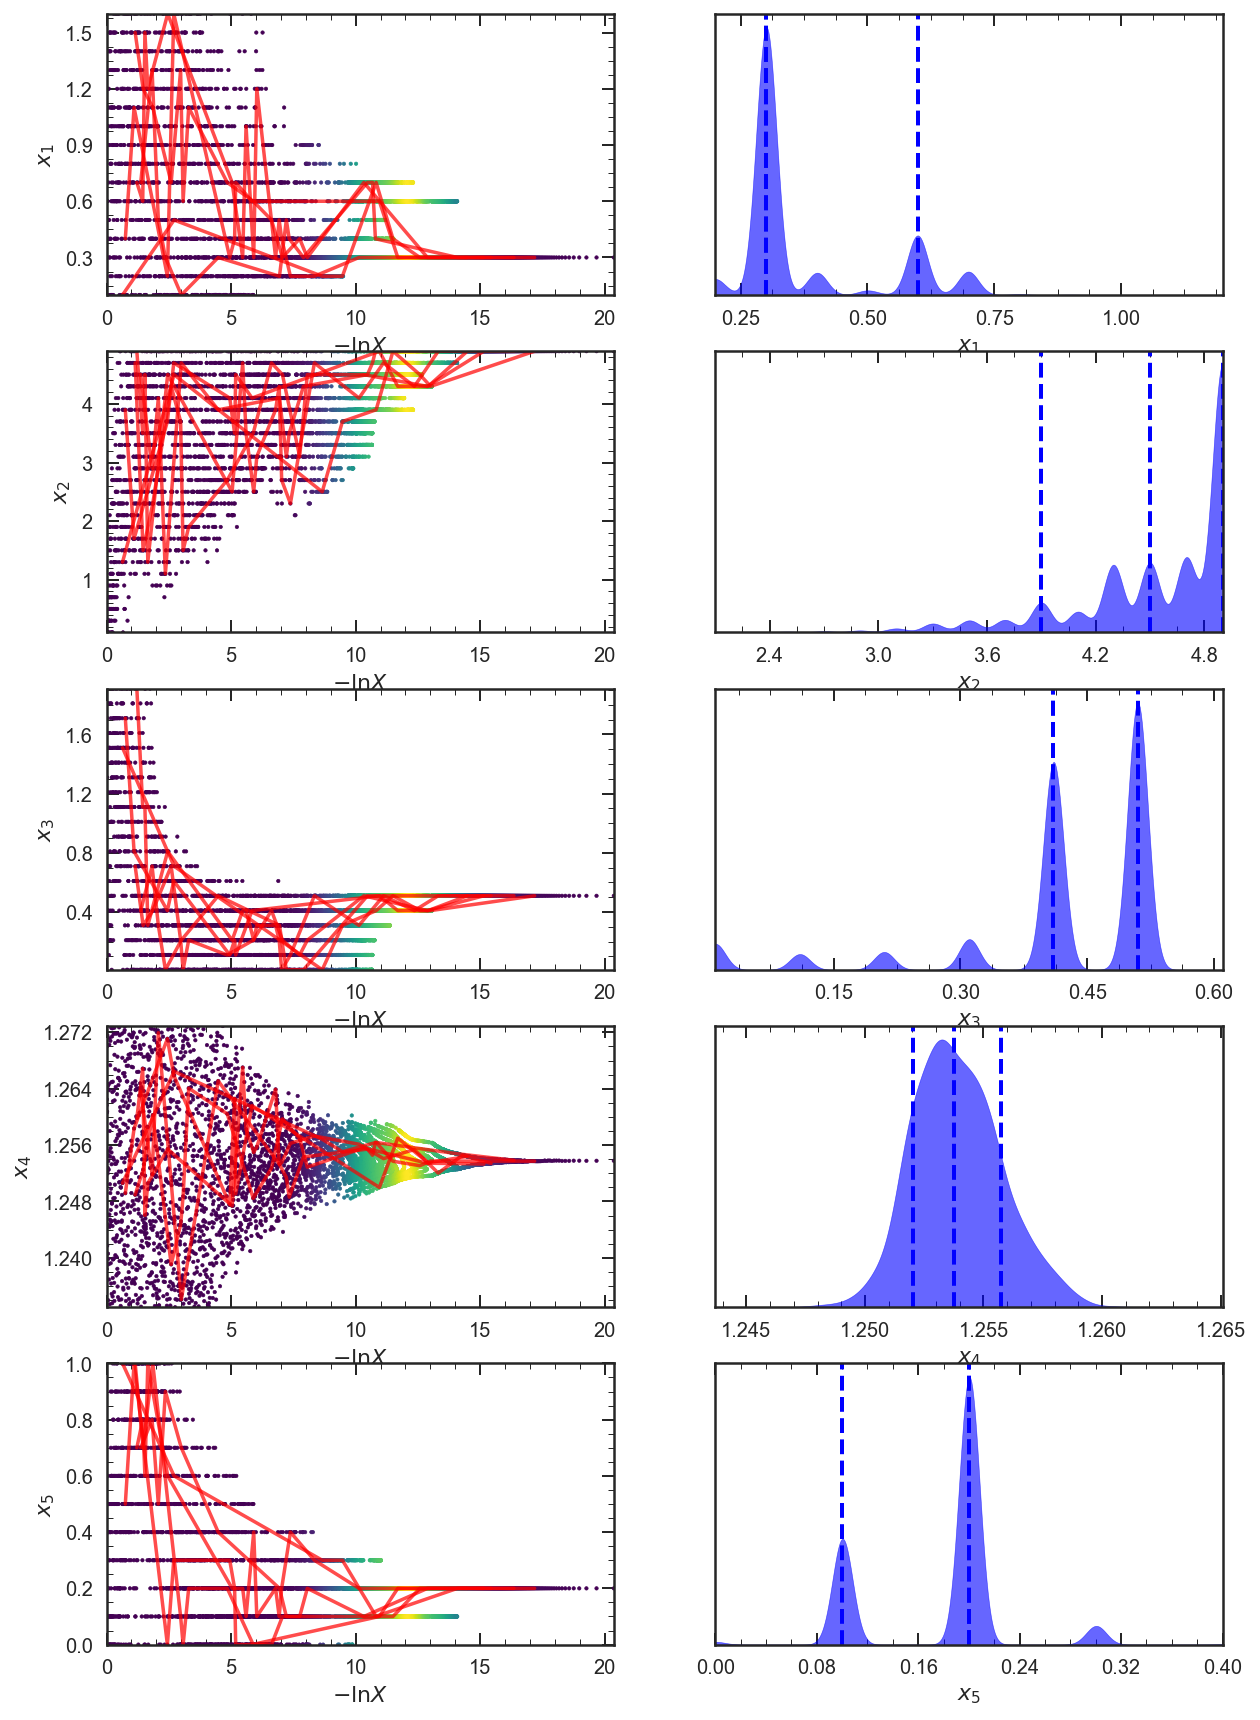

In [32]:
fig, axes = dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 10, 'y': 1.05},
                             trace_cmap='viridis', kde=True,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(5, 2, figsize=(10, 15)))

(<Figure size 1440x1440 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110cf16a0>,
       dtype=object))

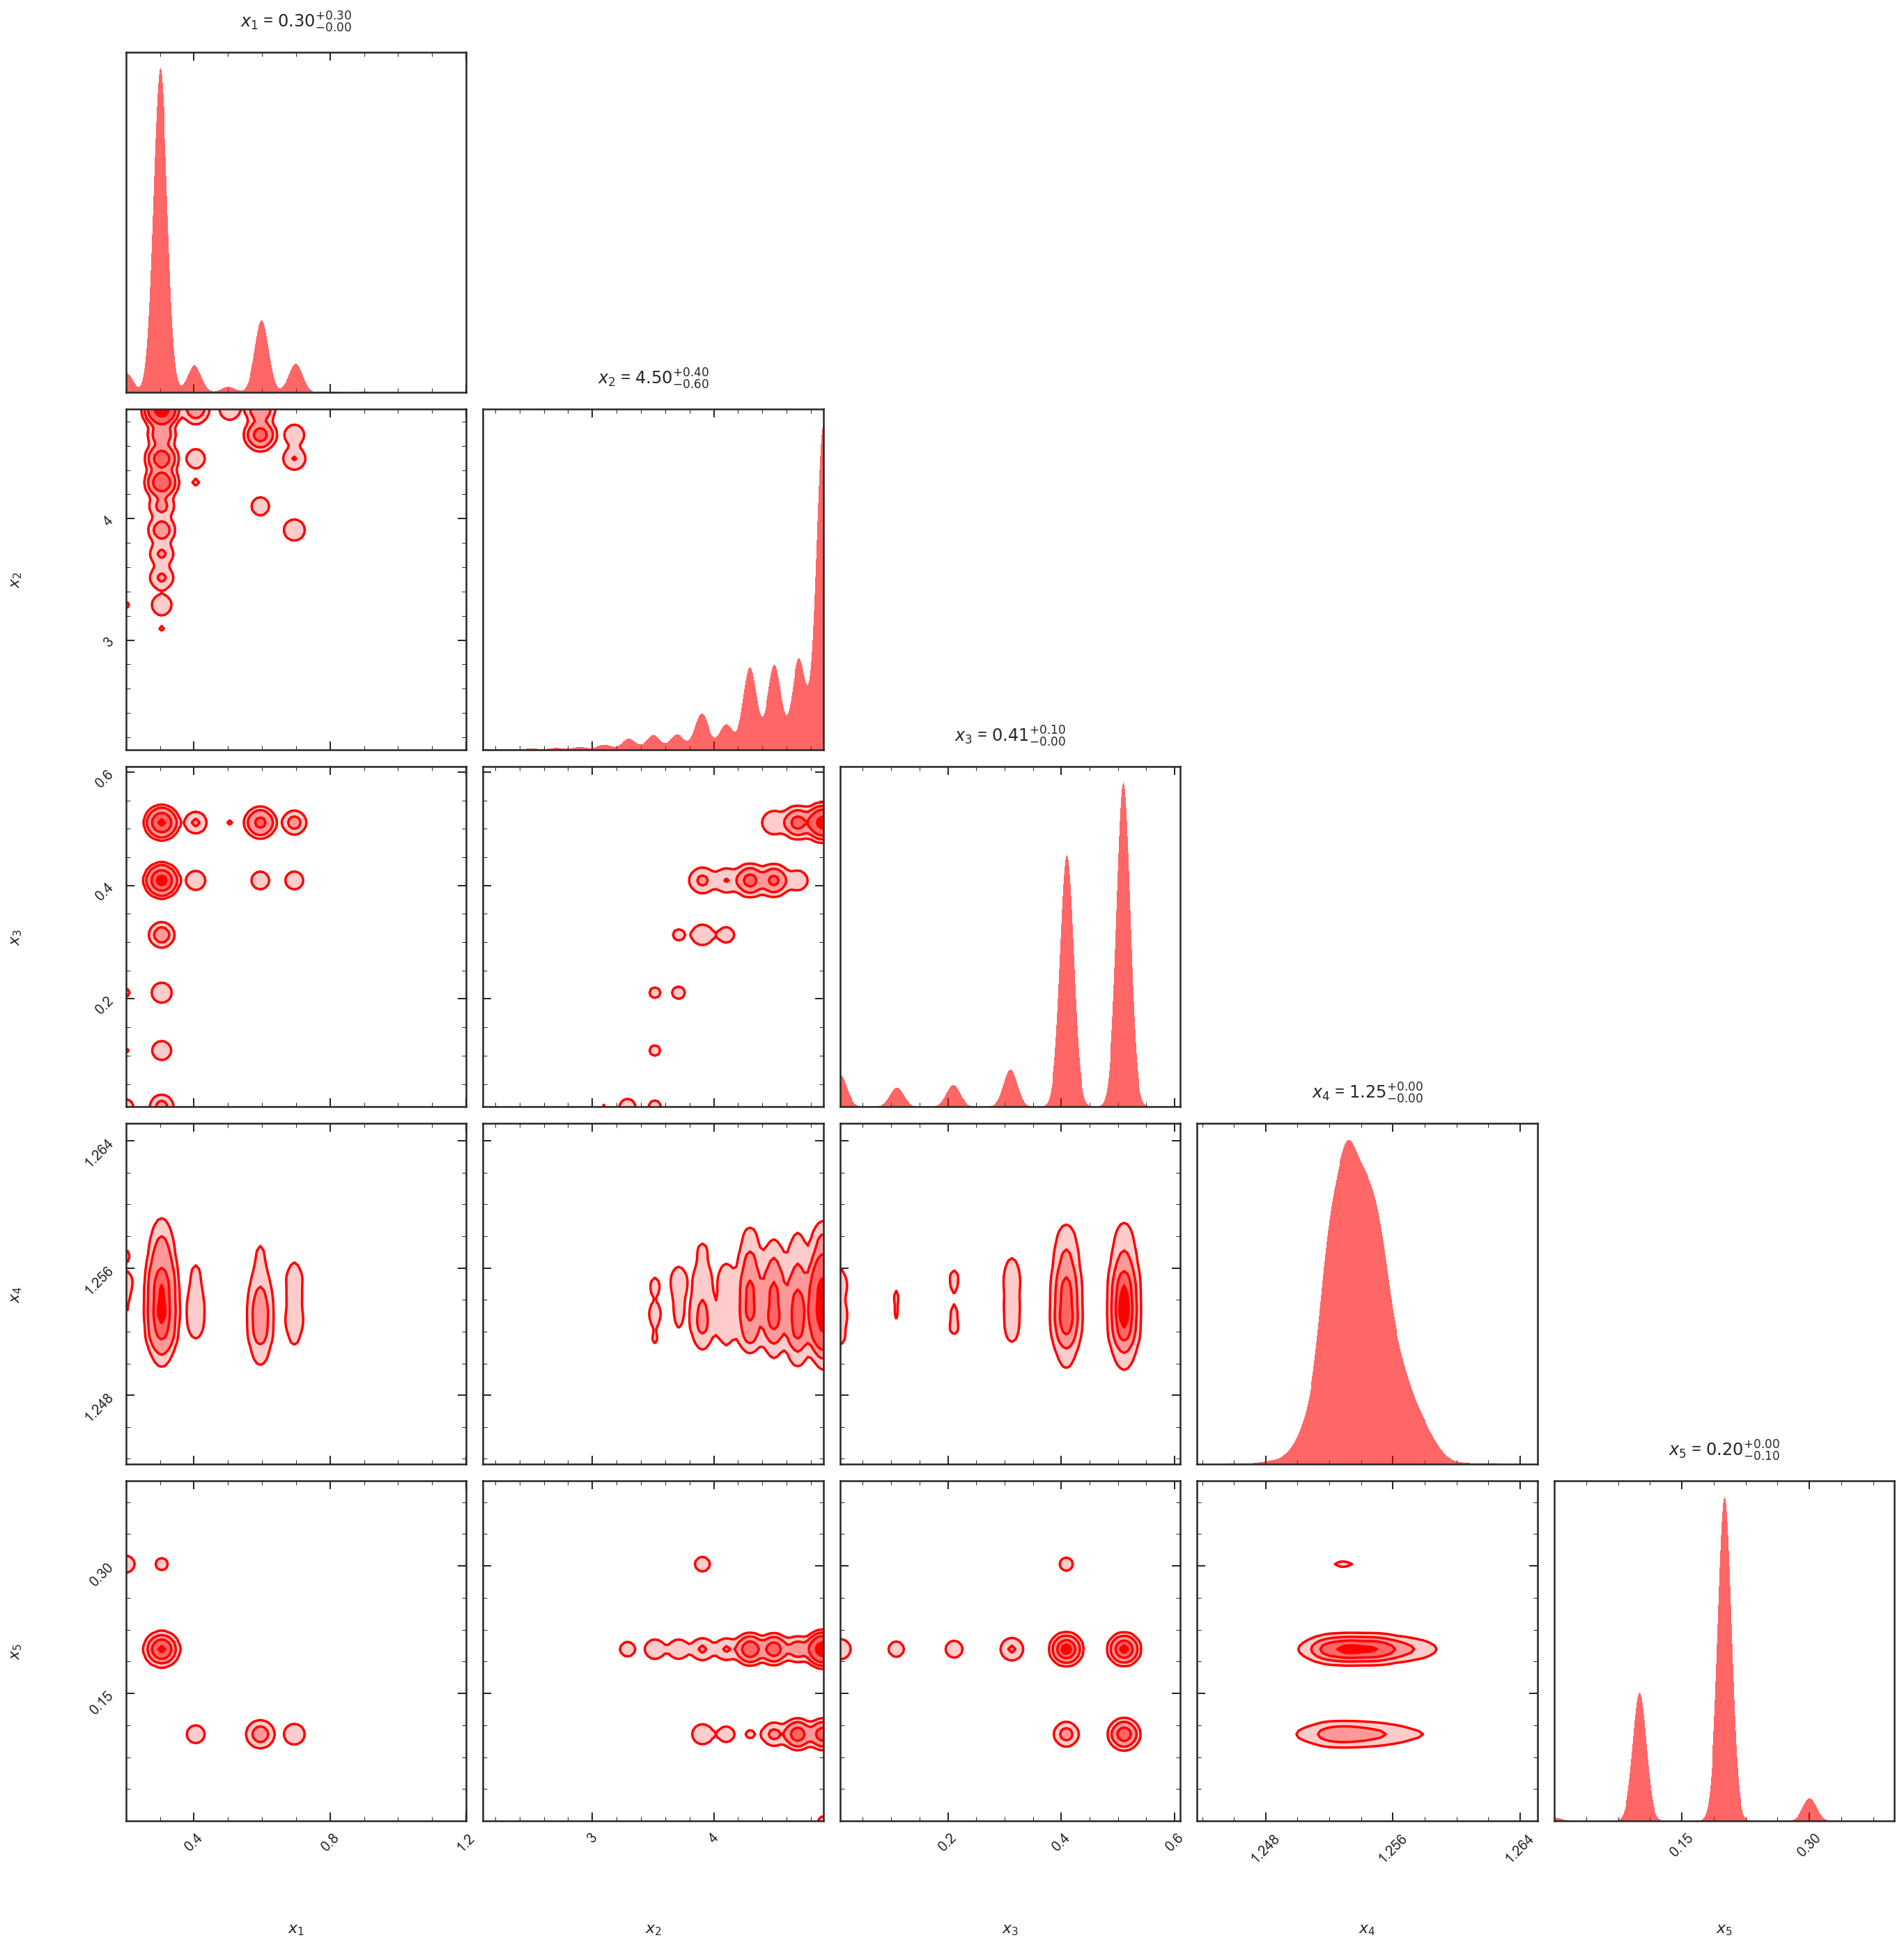

In [33]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.reshape((5, 5))
dyplot.cornerplot(dres, color='red', truths=None, truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes))

In [34]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

weight = np.exp(dres['logwt'] - dres['logz'][-1])
sample = dres['samples'][:,3] 

q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
span = _quantile(sample.T, q, weights=weight)

s = 0.02

bins = int(round(10. / 0.02))
n, b = np.histogram(sample, bins=bins, weights=weight,
                    range=np.sort(span))
n = norm_kde(n, 10.)
x0 = 0.5 * (b[1:] + b[:-1])
y0 = n


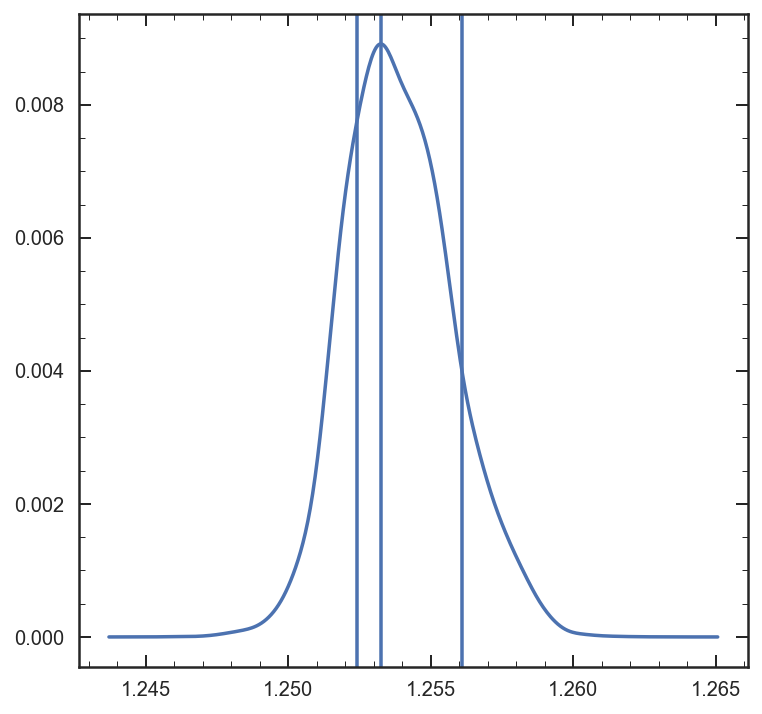

In [38]:
plt.figure(figsize=[6,6])

plt.plot(x0,y0)
plt.axvline(1.25325)
plt.axvline(1.2539 - 0.0015)
plt.axvline(1.2539 + 0.0022)

In [37]:
Highest_density_region(y0 / np.trapz(y0,x0),x0)

(1.253250930323516, 0.0014823214157486664, 0.0022426789739029562)

In [303]:
Gs1 = Gen_spec('GND', 21156, 1.2529, '../beams/o151.0_21156.g102.A.fits', '../beams/o144.0_21156.g141.A.fits',
               g102_lims=[7900, 11300], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = False)  
Gs2 = Gen_spec('GND', 21156, 1.2529, '../beams/o301.0_21156.g102.A.fits', '../beams/o300.0_21156.g141.A.fits',
               g102_lims=[7900, 11300], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = False)  

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [304]:
Bmwv1, Bmflx1 = forward_model_grism(Gs1.Bbeam,wave * (1 + 1.2529),flux)
Bmwv2, Bmflx2 = forward_model_grism(Gs2.Bbeam,wave * (1 + 1.2529),flux)

In [305]:
beams = [Gs1.Bbeam,Gs2.Bbeam]

BFL = np.zeros([len(beams),len(Gs1.Bwv)])

for i in range(len(beams)):
    Bmwv, Bmflx = forward_model_grism(beams[i],wave * (1 + 1.2529),flux)
    BFL[i] = interp1d(Bmwv, Bmflx)(Gs1.Bwv)

BMFL = np.mean(BFL.T,axis=1)
    

In [306]:
C1 = Scale_model(Gs1.Bflx, Gs1.Berr, BFL[0])
C2 = Scale_model(Gs2.Bflx, Gs2.Berr, BFL[1])
C3 = Scale_model(Gs1.Bflx, Gs1.Berr, BMFL)

(0.73, 0.8)

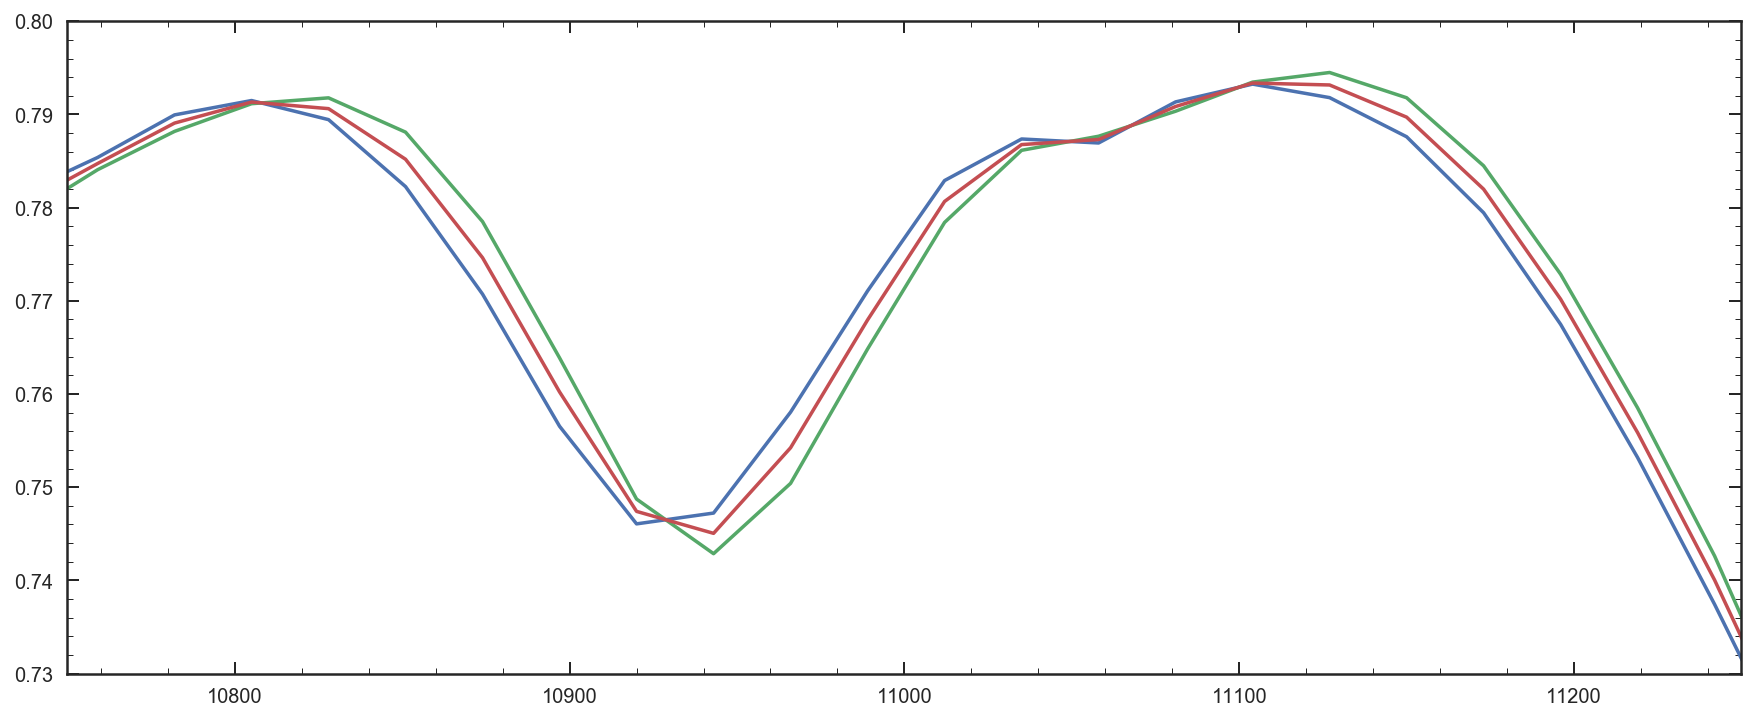

In [308]:
plt.figure(figsize=[15,6])
plt.plot(Gs1.Bwv, C1*BFL[0])
plt.plot(Gs1.Bwv, C2*BFL[1])
plt.plot(Gs1.Bwv,  C3*BMFL)
plt.xlim(10750,11250)
plt.ylim(0.73,.8)
# plt.plot(Gs1.Bwv,  Gs1.Bflx)

In [263]:
print(np.sum((((Gs1.Bflx - C1*Bmfl1) / Gs1.Berr)**2)))
print(np.sum((((Gs2.Bflx - C2*Bmfl2) / Gs2.Berr)**2)))
print(np.sum((((Gs2.Bflx -C3*( (Bmfl1 + Bmfl2) / 2)) / Gs2.Berr)**2)))


99.65635796390544
96.15584600510536
97.59470456179662


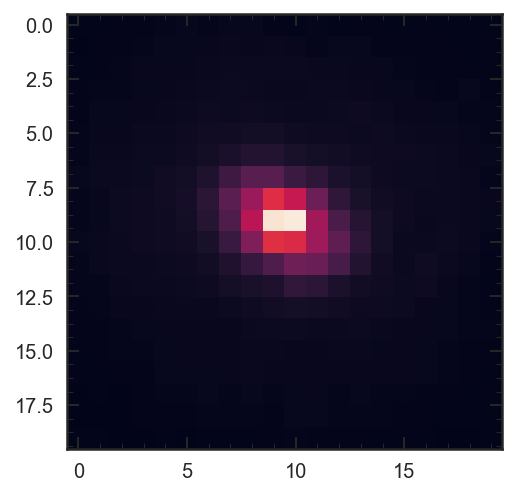

In [243]:
self.lam_beam[self.lam_sort]

In [278]:
Gs1.Bbeam.beam.lam_beam 
# Gs1.Bbeam.beam.lam_sort = np.arange(len(Gs1.Bwv))

array([ 7907.,  7930.,  7953.,  7976.,  7999.,  8022.,  8045.,  8068.,
        8091.,  8114.,  8137.,  8160.,  8183.,  8206.,  8229.,  8252.,
        8275.,  8298.,  8321.,  8344.,  8367.,  8390.,  8413.,  8436.,
        8459.,  8482.,  8505.,  8528.,  8551.,  8574.,  8597.,  8620.,
        8643.,  8666.,  8689.,  8712.,  8735.,  8758.,  8781.,  8804.,
        8827.,  8850.,  8873.,  8896.,  8919.,  8942.,  8965.,  8988.,
        9011.,  9034.,  9057.,  9080.,  9103.,  9126.,  9149.,  9172.,
        9195.,  9218.,  9241.,  9264.,  9287.,  9310.,  9333.,  9356.,
        9379.,  9402.,  9425.,  9448.,  9471.,  9494.,  9517.,  9540.,
        9563.,  9586.,  9609.,  9632.,  9655.,  9678.,  9701.,  9724.,
        9747.,  9770.,  9793.,  9816.,  9839.,  9862.,  9885.,  9908.,
        9931.,  9954.,  9977., 10000., 10023., 10046., 10069., 10092.,
       10115., 10138., 10161., 10184., 10207., 10230., 10253., 10276.,
       10299., 10322., 10345., 10368., 10391., 10414., 10437., 10460.,
      

In [39]:
len(dres.logl), np.where(dres.logl == np.max(dres.logl))

(7277, (array([7276]),))

In [40]:
dres.samples[7276]

array([0.3       , 4.9       , 0.51      , 1.25377875, 0.2       ])